# Alzheimer MRI - VGG16 Transfer Learning on Imbalanced Data (96.4% Acc)

In [1]:
import re, os, random, shutil, gc

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob 
from datasets import load_dataset, concatenate_datasets, Image

from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow import keras
from keras import layers, Sequential, metrics
from keras.applications import VGG16
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

In [3]:
tf.__version__

'2.10.1'

In [4]:
keras.__version__

'2.10.0'

# Table of Contents
1. [Introduction](#introduction)
2. [Exploratory Data Analaysis and Data Pipeline](#paragraph1)
3. [Model Architecture](#paragraph2)
4. [Results & Analaysis](#paragraph3)
5. [Conclusion](#conclusion)

## 1. Introduction <a name="introduction"></a>

GitHub link: https://github.com/machristensen1/alzheimer-mri

For this project, we will task a CNN to classify MRI scans of brains in various stages of dementia.

https://huggingface.co/datasets/Falah/Alzheimer_MRI

The dataset we'll be using (`Falah/Alzheimer_MRI`). There are four labels:

    '0': Mild_Demented
    '1': Moderate_Demented
    '2': Non_Demented
    '3': Very_Mild_Demented

From: https://www.dementiacarecentral.com/aboutdementia/facts/stages/ 

* Very Mild:
    * Forgets names
    * Misplaces familiar objects
    * Symptoms not evident to loved ones or doctors
* Mild:
    * Increased forgetfulness
    * Slight difficulty concentrating
    * Decreased work performance
    * Gets lost more frequently
    * Difficulty finding right words
    * Loved ones begin to notice
* Moderate:
    * Difficulty concentrating
    * Forgets recent events
    * Cannot manage finances
    * Cannot travel alone to new places
    * Difficulty completing tasks
    * In denial about symptoms
    * Socialization problems: Withdraw from friends or family
    * Physician can detect cognitive problems

This dataset is highly imbalanced. This can lead to poor model performance potentially leading to poor patient outcomes. We will attempt to resolve the imbalanced dataset through the following:

* Data augmentation
* Pre-training/transfer learning

For data augmentation, we will be augmenting our dataset through random cropping, zooming, rotation, and noise. We will also be taking advantage of the VGG16 Neural Network commonly used in other image classification tasks. The VGG16 model will be pre-trained on the ImageNet dataset.

Further resources on imbalanced data:


https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

## 2. EDA & Data Pipeline <a name="paragraph1"></a>

In [5]:
# Load the Falah/Alzheimer_MRI dataset
train = load_dataset('Falah/Alzheimer_MRI',split='train')
test = load_dataset('Falah/Alzheimer_MRI',split='test')
dataset = concatenate_datasets([train,test])

In [6]:
dataset.info.features

{'image': Image(mode=None, decode=True, id=None),
 'label': ClassLabel(names=['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented'], id=None)}

In [7]:
print('Number of training examples:', train.shape[0])
print('Number of test examples:', test.shape[0])


Number of training examples: 5120
Number of test examples: 1280


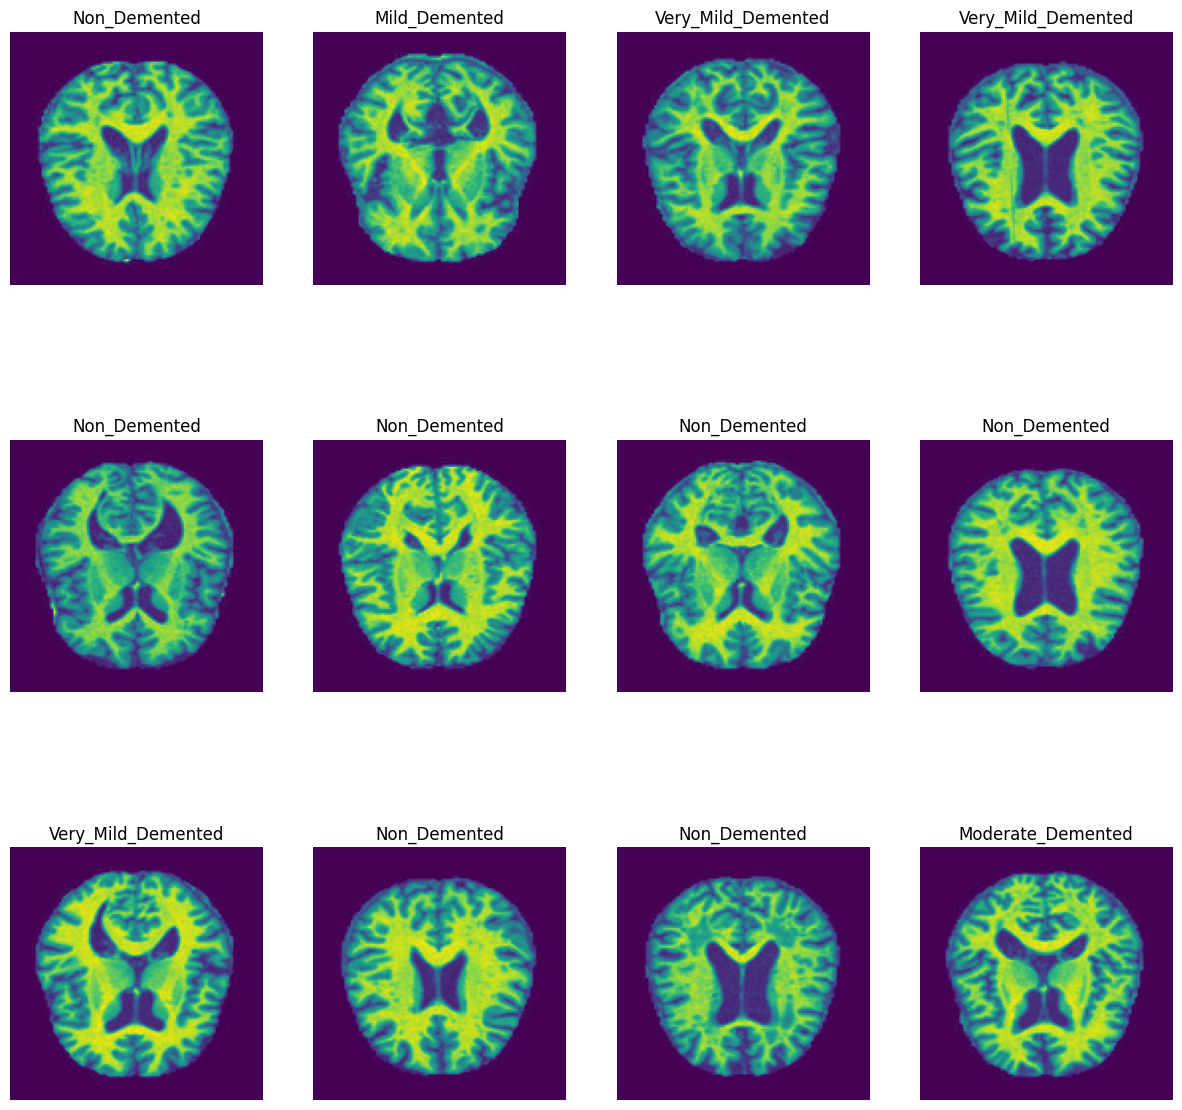

In [8]:
plt.figure(figsize=(15, 15))
for i in range(12):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(dataset[i]['image'])
    plt.title(dataset.features['label'].int2str(dataset[i]['label']))
    plt.axis("off")

In [9]:
train_labels = train.to_pandas()
test_labels = test.to_pandas()

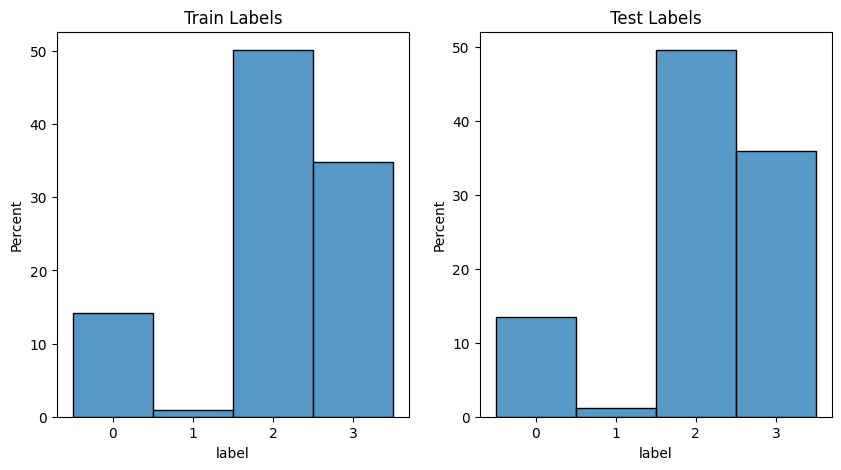

In [10]:
#Plot distribution of data
fig, ax = plt.subplots(1,2, figsize=(10,5))
sns.histplot(data = train_labels, x='label', ax = ax[0], discrete = True, stat = 'percent')
ax[0].set_title("Train Labels")
sns.histplot(data = test_labels, x='label', ax = ax[1], discrete = True, stat = 'percent')
ax[1].set_title("Test Labels")
plt.show()


In [11]:
label_counts = train_labels['label'].value_counts()
label_counts


label
2    2566
3    1781
0     724
1      49
Name: count, dtype: int64

## Data Preprocessing

Although huggingface has their own training/transformation methods, we'll need to cast the huggingface dataset to something useable by keras/tensorflow in order to use the neural network of our choice.

https://huggingface.co/docs/transformers/main/en/tasks/image_classification

https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/image_classification-tf.ipynb#scrollTo=9WM7trfCON_1

In [12]:
NUM_CLASSES = 4
IMAGE_SIZE = 128

In [ ]:
#Augmentation layers
train_data_augmentation = keras.Sequential(
    [
        layers.GaussianNoise(stddev = 0.01), 
        layers.RandomCrop(IMAGE_SIZE, IMAGE_SIZE), 
        layers.Rescaling(scale=1.0 / 127.5, offset=-1),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomTranslation(height_factor=0.2, width_factor=0.2),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="train_data_augmentation",
)

#Normalization layer (rescaling)
data_normalization = keras.Sequential(
    [
        layers.Rescaling(scale=1.0 / 127.5, offset=-1),
    ],
    name="data_normalization",
)


In [14]:
#Convert images to tensors, apply augmentation, normalization
def convert_to_tf_tensor(image: Image):
    np_image = np.array(image)
    tf_image = tf.convert_to_tensor(np_image)
    return tf.expand_dims(tf_image, 0)

#Apply normalization & convert images to tensors
def preprocess_norm(example_batch):
    images = [data_normalization(convert_to_tf_tensor(image.convert("RGB"))) for image in example_batch["image"]]
    example_batch["pixel_values"] = [tf.transpose(tf.squeeze(image)) for image in images]
    return example_batch

#Apply augmentation & convert images to tensors
def preprocess_train(example_batch):
    images = [train_data_augmentation(convert_to_tf_tensor(image.convert("RGB"))) for image in example_batch["image"]]
    example_batch["pixel_values"] = [tf.transpose(tf.squeeze(image)) for image in images]
    return example_batch

In [15]:
#Train Set
train.set_transform(preprocess_train)

#Test Set
test.set_transform(preprocess_norm)

In [ ]:
from transformers import DefaultDataCollator
data_collator = DefaultDataCollator(return_tensors="tf")

#Apply transformations & batch collation
train_set = train.to_tf_dataset(
    columns=["pixel_values"],
    label_cols=["label"],
    shuffle=False,
    batch_size=1,
    collate_fn=data_collator,
    prefetch=False
)

test_set = test.to_tf_dataset(
    columns=["pixel_values"],
    label_cols=["label"],
    shuffle=False,
    batch_size=1,
    collate_fn=data_collator,
    prefetch=False
)


In [17]:
test_set

<MapDataset element_spec=(TensorSpec(shape=(None, 3, 128, 128), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [18]:
#Convert MapDataset to tensor array
def mdstotensors(dataset):
    list_array = list(sum(list(dataset),()))
    image = tf.squeeze(tf.stack(list_array[::2]))
    label = tf.squeeze(tf.stack(list_array[1::2]))
    return image, label

X_train, y_train = mdstotensors(train_set)
X_test, y_test = mdstotensors(test_set)


In [19]:
X_train.shape

TensorShape([5120, 3, 128, 128])

In [21]:
#_onehot encoding
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

def onehot(y):
    encoder = LabelEncoder()
    encoder.fit(y)
    y = encoder.transform(y)
    y = to_categorical(y)
    return y

y_train = onehot(y_train)
y_test = onehot(y_test)

## 3. Model Architecture <a name="paragraph2"></a>

We will be using a slightly modified VGG-16 model for our classifier. This model is one of the best performing for image classification. The main advantages of VGG-16 is that it is a fairly deep yet simple convolutional network which yields high model performance compared to more shallow networks. Additionally, VGG-16 takes advantage of ImageNet for pre-training, which saves us on training time and improves model performance by leveraging transfer learning. VGG16 typically uses 5 convolution blocks with a total of 13 weighted layers, 2 dense fully connected layers, and one dense output layer for a total of 16 layers. 

#### Typical VGG-16 architecture:

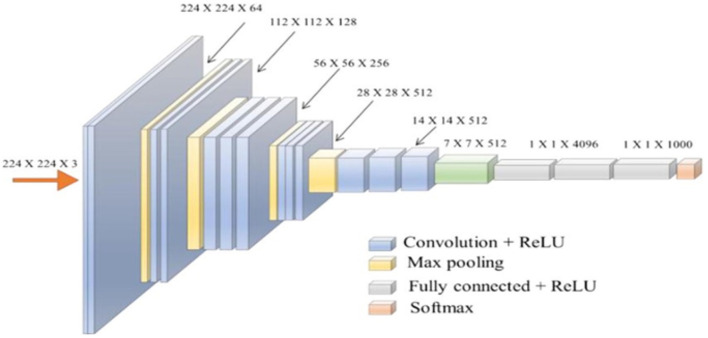

Image sourced from: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10157370/


### Transfer Learning

The typical transfer learning workflow is as follows: 

> The most common incarnation of transfer learning in the context of deep learning is the following workflow:
>    1. Take layers from a previously trained model.
>    2. Freeze them, so as to avoid destroying any of the information they contain during future training rounds.
>    3. Add some new, trainable layers on top of the frozen layers. They will learn to turn the old features into predictions on a new dataset.
>    4. Train the new layers on your dataset.

However, taking a look at the ImageNet database, it doesn't make sense to freeze the layers as a model trained on ImageNet is better suited for general object recognition (e.g. classifying between `dog` and `cat`). We can either unfreeze the model, or keep the frozen model and fine tune it by re-training it. Either way, we should use a fairly low learning rate to prevent overfitting.

Since we are not freezing the VGG16 base model, we will need to make up for the additional computation time. To that end, we will be implementing our own dense layers, dropping one of the dense layers and reducing the dimensionality of the remaining fully connected layer. The typical VGG16 model has two Dense layers with a dimension of 4000, ours will be a single dense layer with a dimension of 128.

https://keras.io/guides/transfer_learning/ 


### Model Structure

* VGG Base Model
    * Convolution Block 1
        * Convolution -> Convolution -> Maxpool
    * Convolution Block 2
        * Convolution -> Convolution -> Maxpool
    * Convolution Block 3
        * Convolution -> Convolution -> Convolution -> Maxpool
    * Convolution Block 4
        * Convolution -> Convolution -> Convolution -> Maxpool
    * Convolution Block 5
        * Convolution -> Convolution -> Convolution -> Maxpool
* Flatten & Dropout (reduce overfitting)
* Fully Connected Dense Network
* Flatten & Dropout
* Output layer

https://keras.io/api/applications/vgg/ 

In [23]:
keras.backend.set_image_data_format('channels_first')

def model_def(base_model):

  model = Sequential()
  model.add(layers.Input(shape=(3, IMAGE_SIZE, IMAGE_SIZE)))
  model.add(base_model) 
  model.add(layers.Flatten())  
  model.add(layers.BatchNormalization())
  model.add(layers.Dropout(0.3)) 
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.Dropout(0.2)) 
  model.add(layers.Dense(4, activation='softmax')) 

  return model

In [24]:
model_vgg = model_def(
    VGG16(
        input_shape=(3, IMAGE_SIZE,IMAGE_SIZE), 
        include_top=False, #drops the 3 dense layers at the end of the model
        weights="imagenet"
    )
)
model_vgg.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512, 4, 4)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 batch_normalization (BatchN  (None, 8192)             32768     
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 128)               1048704   
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                        

In [ ]:
import tensorflow_addons as tfa

METRICS = [
    metrics.CategoricalAccuracy(name='acc'),
    metrics.AUC(name = 'auc'),
    tfa.metrics.F1Score(num_classes = 4, average = "macro")
]

In [26]:
# Callbacks
early_stopping = EarlyStopping(
    monitor ='val_acc',
    verbose = True,
    patience = 5,
    restore_best_weights=True
)

In [27]:
model_vgg.compile(
    optimizer=Adam(learning_rate=5e-5), #Low learning rate due to pre-trained model
    loss='categorical_crossentropy',
    metrics=METRICS,
)

In [28]:
BATCH_SIZE = 64

history = model_vgg.fit(
    X_train,
    y_train,
    batch_size = BATCH_SIZE,
    validation_split = 0.2,
    shuffle = True,
    epochs = 50,
    callbacks = [early_stopping]
)

Epoch 1/50
64/64 [==============================] - 26s 204ms/step - loss: 1.6603 - acc: 0.3877 - auc: 0.6409 - f1_score: 0.3126 - val_loss: 0.9693 - val_acc: 0.5811 - val_auc: 0.8381 - val_f1_score: 0.3914
Epoch 2/50
64/64 [==============================] - 13s 203ms/step - loss: 1.2499 - acc: 0.5317 - auc: 0.7700 - f1_score: 0.4091 - val_loss: 3.4351 - val_acc: 0.1436 - val_auc: 0.4568 - val_f1_score: 0.0718
Epoch 3/50
64/64 [==============================] - 13s 204ms/step - loss: 0.9791 - acc: 0.6548 - auc: 0.8545 - f1_score: 0.5037 - val_loss: 3.4128 - val_acc: 0.5000 - val_auc: 0.7160 - val_f1_score: 0.1679
Epoch 4/50
64/64 [==============================] - 13s 202ms/step - loss: 0.6524 - acc: 0.7712 - auc: 0.9306 - f1_score: 0.6020 - val_loss: 0.8392 - val_acc: 0.6855 - val_auc: 0.9169 - val_f1_score: 0.4074
Epoch 5/50
64/64 [==============================] - 13s 202ms/step - loss: 0.3720 - acc: 0.8782 - auc: 0.9757 - f1_score: 0.7318 - val_loss: 0.5670 - val_acc: 0.7734 - val_

# 4. Results & Analysis <a name="paragraph3"></a>

Our model seems to perform exceptionally well, with an accuracy of `0.96`. Our auc was very high, indicating high predictive power. Given the dataset was fairly imbalanced, an F1 score of `0.942` indicates that our model is able to generalize well even on the parameters. 

* Hyperparameters: 
    * By far the most impactful was learning rate - my initial learning rate of `1e-2` was too high and led to overfitting (`val_loss` would not stabilize).
    * Early stopping allowed us to save the best performing model.
    * Increasing the dimension of the dense network and adding another fully connected layer would increase model performance.
    
* Troubleshooting:
    * Using huggingface's native dataset was a nightmare to get to work with keras. It took me a while before I could find a way to get a properly formatted tensor array. However, huggingface did offer the dataset in `parquet` format, which I didn't notice until too late.
    * If `validation_split` is too small, sometimes validation batches won't contain any `Moderate_Demented` samples, leading to huge `val_loss` numbers.

* Additional notes
    * Bootstrapping/oversampling underreprsented classes is another way to handle imbalanced data.
    * Besides ImageNet, there are other datasets that may be better suited for MRI image classification (e.g. RadImageNet)
    * Other model considerations:
        * XGBoost is a model by NVIDIA that us designed to readily handle imbalanced data.
        * SMOTE (Synthetic Minority Oversampling Technique) is a type of data augmentation technique that is commonly paired with unsupervised learning models like Decision Trees for imbalanced data.

In [33]:
model_vgg.evaluate(X_test, y_test, return_dict = "True")

40/40 [==============================] - 1s 27ms/step - loss: 0.1160 - acc: 0.9641 - auc: 0.9965 - f1_score: 0.9426


{'loss': 0.11599425226449966,
 'acc': 0.964062511920929,
 'auc': 0.996472954750061,
 'f1_score': 0.9425805807113647}

In [34]:
preds = model_vgg.predict(X_test)

40/40 [==============================] - 1s 34ms/step


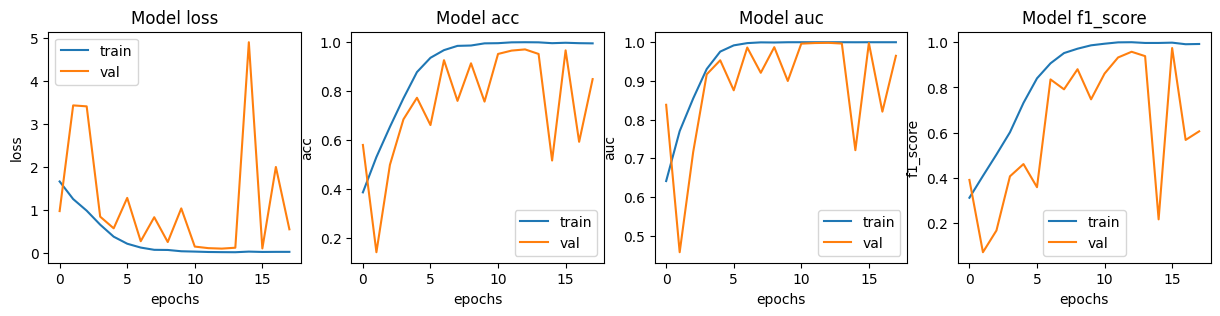

In [79]:
fig, ax = plt.subplots(1, 4, figsize=(15, 3))
ax = ax.ravel()

for i, met in enumerate(["loss","acc", "auc", "f1_score"]):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history["val_" + met])
    ax[i].set_title("Model {}".format(met))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(met)
    ax[i].legend(["train", "val"])

[Text(0, 0.5, 'Mild_Demented'),
 Text(0, 1.5, 'Moderate_Demented'),
 Text(0, 2.5, 'Non_Demented'),
 Text(0, 3.5, 'Very_Mild_Demented')]

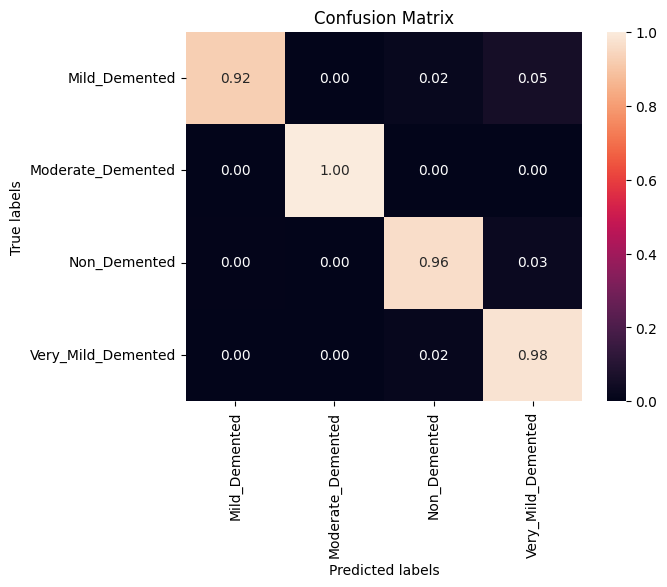

In [85]:
cm = confusion_matrix(np.argmax(preds, axis = 1), np.argmax(y_test, axis = 1))

#Normalize due to data imbalance
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

labels = dataset.features["label"].names

ax = plt.subplot()
sns.heatmap(cm_norm, annot=True, fmt='.2f', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'),
ax.set_title('Confusion Matrix'),
ax.set_xticklabels(labels, rotation = 90)
ax.set_yticklabels(labels, rotation = 0)

# Conclusion <a name="conclusion"></a>

Even on imbalanced datasets, with proper data augmentation and pretraining, we are able to achieve a high degree of accuracy. While there is currently no known treatment for Alzheimer's, early detection of the disease can help with palliative care and cognitive therapy. For this purpose, a high degree of model accuracy is especially important, but the ratio of people with dementia to those without can be highly skewed, especially if we want to properly identify how far along a person is with the disease in order to devise a treatment plan.